In [1]:
import paddle
from paddleocr import PaddleOCR,draw_ocr
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

/home/yegekucuk/venv/bitirme/lib/python3.12/site-packages/paddle/base/framework.py:688: UserWarning: You are using GPU version Paddle, but your CUDA device is not set properly. CPU device will be used by default.
  warnings.warn(


In [ ]:
# Check if any GPU is available
gpu_available  = paddle.device.is_compiled_with_cuda()
print("GPU available:", gpu_available)

# Create OCR object and disable GPU to avoid CUDA issues
ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu = False)

GPU available: True
[2025/03/12 17:21:50] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/yegekucuk/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/yegekucuk/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='

[2025/03/12 17:21:52] ppocr DEBUG: dt_boxes num : 43, elapsed : 0.1833946704864502
[2025/03/12 17:21:52] ppocr DEBUG: cls num  : 43, elapsed : 0.06735992431640625
[2025/03/12 17:21:56] ppocr DEBUG: rec_res num  : 43, elapsed : 4.607137680053711
[[[[[432.0, 142.0], [1910.0, 165.0], [1907.0, 366.0], [428.0, 343.0]], ('WHOLE FOODS', 0.9677639603614807)], [[[812.0, 371.0], [1515.0, 348.0], [1519.0, 453.0], [815.0, 476.0]], ('MARKET', 0.9977173805236816)], [[[608.0, 622.0], [1625.0, 609.0], [1626.0, 697.0], [609.0, 710.0]], ('Sunnyvale SVL 408-419-1290', 0.9515756964683533)], [[[716.0, 706.0], [1470.0, 684.0], [1473.0, 768.0], [719.0, 790.0]], ('150 E Mc Kin1ey Ave', 0.9034724235534668)], [[[716.0, 782.0], [1470.0, 755.0], [1473.0, 843.0], [719.0, 870.0]], ('Sunnyvale,CA 94086', 0.9483845233917236)], [[[1580.0, 830.0], [1861.0, 850.0], [1856.0, 926.0], [1574.0, 906.0]], ('$1.29F', 0.9768164157867432)], [[[288.0, 844.0], [1118.0, 857.0], [1117.0, 933.0], [287.0, 919.0]], ('KTTL SEA SALT POT 

(-0.5, 2267.5, 4031.5, -0.5)

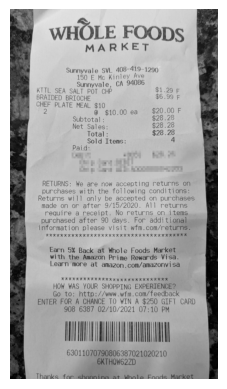

In [ ]:
# Example 1

# Image path
image_path = "./kaggle/images/5.jpg"

# Open the image and apply image preprocessing
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply OCR
extracted_text = ocr.ocr(image, cls=True)

# Print
print(extracted_text)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
plt.axis("off")

In [ ]:
def process_ocr_result(ocr_result):
    processed = []
    for page in ocr_result:
        for line in page:
            if not line:  # Boş satırları atla
                continue
            coordinates, (text, confidence) = line
            processed.append({
                "text": text,
                "confidence": float(confidence),
                "coordinates": [[float(x[0]), float(x[1])] for x in coordinates]
            })
    return processed

# Process OCR results
processed_data = process_ocr_result(extracted_text)

In [ ]:
# Create a pandas DataFrame
df = pd.DataFrame(processed_data)
print(df.head())

                         text  confidence  \
0                 WHOLE FOODS    0.967764   
1                      MARKET    0.997717   
2  Sunnyvale SVL 408-419-1290    0.951576   
3         150 E Mc Kin1ey Ave    0.903472   
4          Sunnyvale,CA 94086    0.948385   

                                         coordinates  
0  [[432.0, 142.0], [1910.0, 165.0], [1907.0, 366...  
1  [[812.0, 371.0], [1515.0, 348.0], [1519.0, 453...  
2  [[608.0, 622.0], [1625.0, 609.0], [1626.0, 697...  
3  [[716.0, 706.0], [1470.0, 684.0], [1473.0, 768...  
4  [[716.0, 782.0], [1470.0, 755.0], [1473.0, 843...  


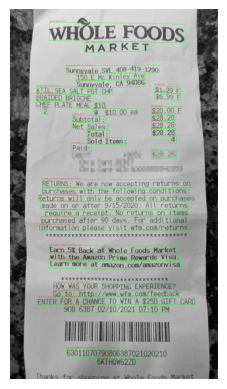

In [ ]:
def visualize_results(image, processed_data):
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for item in processed_data:
        pts = np.array(item["coordinates"], dtype=np.int32)
        cv2.polylines(image, [pts], isClosed=True, color=(0,255,0), thickness=2)
        cv2.putText(image, 
                    f"{item['text']} ({item['confidence']:.2f})", 
                    (int(pts[0][0]), int(pts[0][1]-5)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, 
                    (0,0,255), 
                    1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Visualize results
visualize_results(image, processed_data)

In [ ]:
# Save the result as json file
with open("ocr_results.json", "w") as f:
    json.dump(extracted_text, f)

In [24]:
# Dokuman kaç sayfa?
print(len(extracted_text))
# Her sayfada kaç farklı metin çıkarılmış?
print(len(extracted_text[0]))
# Her sayfadaki tespit edilen metinlerin koordinatlarını tutan bir liste ve (metin,trust), 2 olmalı
print(len(extracted_text[0][0]))
# Koordinat sayısı, 4 olmalı
print(len(extracted_text[0][0][0]))
# Tuple, 2 olmalı
print(len(extracted_text[0][0][1]))
# İlk metini ve güven skorunu yazdıralım
print(f"Metin: {extracted_text[0][0][1][0]}")
print(f"Güven skoru: {extracted_text[0][0][1][1]}")

1
39
2
4
2
Metin: WHOLE FOODS
Güven skoru: 0.9677639603614807
